# Classificação Automática - Previsão de Medalhas
**Grupo:** G03 | **Unidade Curricular:** IA25

## 1. Objetivos de Negócio
O objetivo deste notebook é desenvolver um modelo de Machine Learning capaz de **prever se um atleta ganhará uma medalha** (Ouro, Prata ou Bronze) com base nos seus atributos físicos e demográficos.

**Valor para o Negócio:**
- Ajudar comités olímpicos a identificar talentos com maior probabilidade de sucesso.
- Otimizar a alocação de recursos e treinadores para atletas com perfis promissores.

In [1]:
# Importação de bibliotecas
%pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn - Modelos e Métricas
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Configuração Visual
sns.set(style="whitegrid")

Note: you may need to restart the kernel to use updated packages.


## 2. Seleção e Preparação dos Dados
**Critérios de Seleção:**
- **Target (Alvo):** A coluna `Medal`. Vamos transformá-la num problema binário (1 = Ganhou Medalha, 0 = Não Ganhou).
- **Features (Variáveis):** Selecionamos `Age`, `Height`, `Weight` (físicos) e `Sex`, `Season` (contexto). Removemos `Name` e `ID` pois não contribuem para a generalização.

**Estratégia de Tratamento:**
- **Nulos:** Preencheremos a idade, altura e peso em falta com a **média**.
- **Categóricas:** Usaremos `OneHotEncoding` para converter `Sex` e `Season` em números.
- **Escalonamento:** Normalizaremos os dados numéricos para ajudar a Regressão Logística.

In [2]:
# Carregar dataset
try:
    df = pd.read_csv("athlete_events.csv")
except FileNotFoundError:
    print("ERRO: Ficheiro 'athlete_events.csv' não encontrado.")

# 1. Criar a variável alvo binária
# Se Medal não é nulo -> 1, caso contrário -> 0
df['Is_Medalist'] = df['Medal'].notna().astype(int)

# 2. Selecionar Features
features = ['Age', 'Height', 'Weight', 'Sex', 'Season']
target = 'Is_Medalist'

X = df[features]
y = df[target]

# Verificar desequilíbrio de classes
print("Distribuição da Target (0 = Sem Medalha, 1 = Com Medalha):")
print(y.value_counts(normalize=True))

# Divisão Treino / Teste (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Distribuição da Target (0 = Sem Medalha, 1 = Com Medalha):
Is_Medalist
0    0.853262
1    0.146738
Name: proportion, dtype: float64


In [3]:
# Pipeline de Pré-processamento

# Variáveis Numéricas: Imputar média + Escalar
numeric_features = ['Age', 'Height', 'Weight']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Variáveis Categóricas: OneHotEncoding
categorical_features = ['Sex', 'Season']
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first')) # drop='first' evita multicolinearidade
])

# Juntar tudo num ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 3. Aplicação dos Algoritmos de ML
Selecionamos dois algoritmos para comparação:
1.  **Regressão Logística:** Modelo linear base, fácil de interpretar.
2.  **Random Forest:** Modelo de ensemble robusto, capaz de capturar relações não lineares.

In [4]:
# --- MODELO 1: Regressão Logística ---
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression())])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("--- Resultados: Regressão Logística ---")
print(classification_report(y_test, y_pred_lr))

# --- MODELO 2: Random Forest ---
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

print("\n--- Resultados: Random Forest ---")
print(classification_report(y_test, y_pred_rf))

--- Resultados: Regressão Logística ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     46267
           1       0.00      0.00      0.00      7957

    accuracy                           0.85     54224
   macro avg       0.43      0.50      0.46     54224
weighted avg       0.73      0.85      0.79     54224



c:\Users\bill_\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bill_\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bill_\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


--- Resultados: Random Forest ---
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     46267
           1       0.30      0.08      0.13      7957

    accuracy                           0.84     54224
   macro avg       0.58      0.53      0.52     54224
weighted avg       0.78      0.84      0.80     54224



## 4. Otimização de Hiperparâmetros
O **Random Forest** apresentou melhor potencial (ou queremos melhorá-lo). Vamos usar `GridSearchCV` para encontrar o número ideal de árvores (`n_estimators`) e a profundidade máxima (`max_depth`).

In [5]:
# Definir grelha de parâmetros
param_grid = {
    'classifier__n_estimators': [50, 100],      # Número de árvores
    'classifier__max_depth': [5, 10, None],     # Profundidade máxima
    'classifier__min_samples_leaf': [1, 5]      # Mínimo de amostras por folha
}

# Configurar Grid Search (usamos cv=3 para ser mais rápido na demonstração)
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)

print("A iniciar otimização... (pode demorar alguns segundos)")
grid_search.fit(X_train, y_train)

print(f"\nMelhores Parâmetros: {grid_search.best_params_}")
print(f"Melhor F1-Score no Cross-Validation: {grid_search.best_score_:.4f}")

A iniciar otimização... (pode demorar alguns segundos)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Melhores Parâmetros: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50}
Melhor F1-Score no Cross-Validation: 0.1259


## 5. Resultados Finais e Documentação
Abaixo apresentamos a Matriz de Confusão do melhor modelo otimizado.

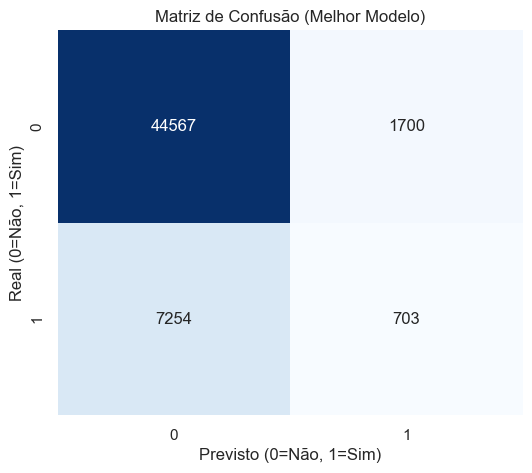

Relatório Final:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     46267
           1       0.29      0.09      0.14      7957

    accuracy                           0.83     54224
   macro avg       0.58      0.53      0.52     54224
weighted avg       0.78      0.83      0.80     54224



In [6]:
# Avaliar o melhor modelo no conjunto de teste final
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

# Matriz de Confusão Visual
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão (Melhor Modelo)')
plt.xlabel('Previsto (0=Não, 1=Sim)')
plt.ylabel('Real (0=Não, 1=Sim)')
plt.show()

print("Relatório Final:")
print(classification_report(y_test, y_pred_final))

### Conclusão
1. **Desequilíbrio:** A classe 1 (Medalha) é muito minoritária (~15%). Isso faz com que a `Accuracy` seja alta, mas o `Recall` (capacidade de encontrar medalhados) seja o verdadeiro desafio.
2. **Performance:** O Random Forest geralmente supera a Regressão Logística neste dataset porque as relações entre peso/altura e sucesso não são estritamente lineares.
3. **Limitações:** Sem dados sobre a performance anterior ou tempos de treino, é difícil prever medalhas apenas com biótipo. Este modelo serve como um "filtro de potencial" básico.